This notebook shows how to load samples from PASTIS using the dataloaders provided in the repository. 

In [4]:
#Fill these file paths with the locations on your machine. 
PATH_TO_CODE = '/Users/rathorology/Projects/pastis-benchmark/code' # path to the code folder of the repo
PATH_TO_PASTIS = '/Users/rathorology/Projects/pastis-benchmark/PASTIS'
PATH_TO_PASTISR = '/path/PASTIS-R'
PATH_TO_PASTISR_pixel = '/path/PASTIS-R_PixelSet/'


import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

def get_radar(x, batch_index=0, t_show=6, orbit='D'):
    """Utility function to get a displayable image 
    from a Sentinel-1 time series.
    """
    im = x['S1{}'.format(orbit)][batch_index, t_show].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

/var/folders/vt/05_4dc9179l5rlbm9rhb3plr0000gn/T/ipykernel_29624/2421210785.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


# PASTIS 

In [14]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='instance')
# If you only need to evaluate semantic segmentation use target='semantic'

dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .
Done.
Dataset ready.


In [15]:
# Loading a batch from the dataloader
(x, dates), y = dl.__iter__().__next__()

# x is a dictionary thay contains the Sentinel-2 time series
# in the 'S2' key, shape: B x T x C x H x W
print(x['S2'].shape)
# dates contains the observation dates of each image, shape: B x T
print(dates['S2'].shape)
# y contains the different ground truth annotations used for panoptic segmentation
(
    target_heatmap,
    instance_ids,
    pixel_to_instance_mapping,
    instance_bbox_size,
    object_semantic_annotation,
    pixel_semantic_annotation,
) = y.split((1, 1, 1, 2, 1, 1), dim=-1)


torch.Size([2, 43, 10, 128, 128])
torch.Size([2, 43])


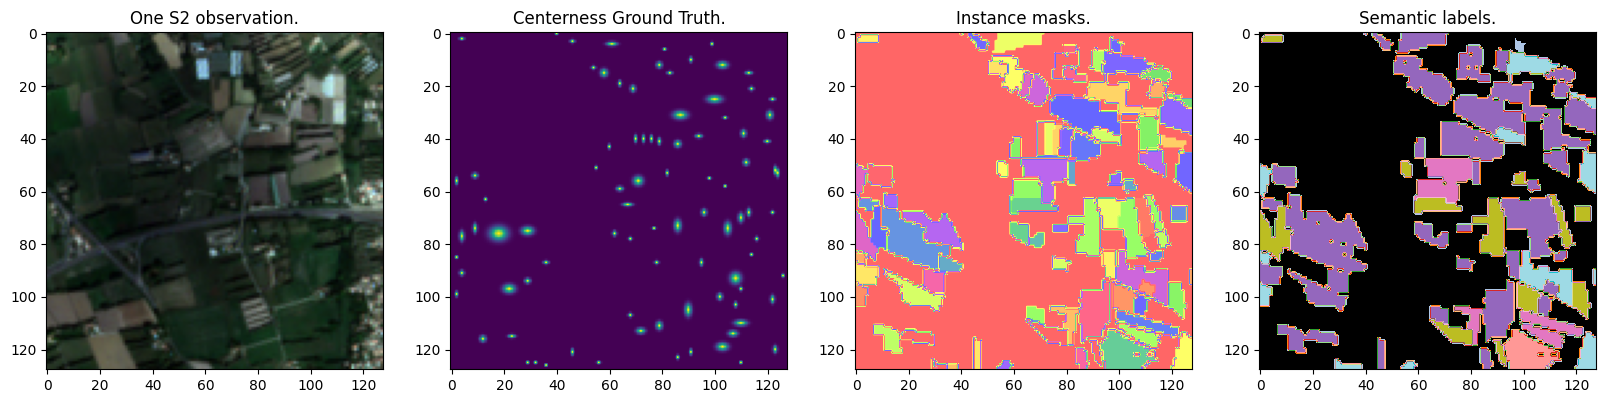

In [10]:
bid = 0 # Which element of the batch to plot

fix, axes = plt.subplots(1,4, figsize=(20,20))

axes[0].imshow(get_rgb(x, batch_index=bid))
axes[1].imshow(target_heatmap[bid].squeeze())
axes[2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[3].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0].set_title('One S2 observation.')
axes[1].set_title('Centerness Ground Truth.')
axes[2].set_title('Instance masks.')
axes[3].set_title('Semantic labels.')

plt.show()